
# Crashspot — Week 5 Starter

**Focus:** Model prep + baseline ML (Logistic Regression, Random Forest) for crash risk classification.

This notebook:
- Loads cleaned crash data (Louisiana statewide and/or Monroe case study).
- Engineers ML features (time-of-day, day-of-week, etc.).
- Defines a simple binary target: **multi-vehicle crash** (`VE_TOTAL >= 2`).
- Splits into train/test and runs baseline models.
- Saves evaluation plots and feature table for downstream work.
>
> - Inputs:
>   `data_clean/fars_la_2022_2023.geojson`
>   `data_clean/fars_monroe_2022_2023_clean.geojson`
>   `data_clean/monroe_roads_with_crash_counts.geojson` (from Week 3)
> - Outputs:
>   `docs/figures/week5_model_eval.png`
>   `docs/figures/week5_rf_feature_importance.png`
>   `data_clean/week5_features.csv`


In [7]:

# 1) Imports & paths
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

# Plotting
import matplotlib.pyplot as plt

# Project paths (adjust if your repo root differs)
PROJECT_ROOT = Path.cwd().parent
DATA_CLEAN  = PROJECT_ROOT / "data_clean"
DOCS        = PROJECT_ROOT / "docs"
FIGS        = DOCS / "figures"
MAPS        = DOCS / "maps"

FIGS.mkdir(parents=True, exist_ok=True)

FARS_LA   = DATA_CLEAN / "fars_la_2022_2023.geojson"
FARS_MON  = DATA_CLEAN / "fars_monroe_2022_2023.geojson"
ROADS_JN  = DATA_CLEAN / "monroe_roads_with_crash_counts.geojson"  # optional

EVAL_PNG  = FIGS / "week5_model_eval.png"
RF_IMP_PNG= FIGS / "week5_rf_feature_importance.png"
FEATS_CSV = DATA_CLEAN / "week5_features.csv"

print("Using project root:", PROJECT_ROOT)
print("Exists LA?:", FARS_LA.exists(), "| Exists Monroe?:", FARS_MON.exists())
print("Optional roads join file?:", ROADS_JN.exists())


Using project root: /Users/himalranabhat/Desktop/Crashspot
Exists LA?: True | Exists Monroe?: True
Optional roads join file?: True


In [8]:

# 2) Load the best-available dataset (prefered Monroe)
def load_best():
    if FARS_MON.exists():
        gdf = gpd.read_file(FARS_MON)
        src = "Monroe"
    elif FARS_LA.exists():
        gdf = gpd.read_file(FARS_LA)
        src = "Louisiana"
    else:
        raise FileNotFoundError("No cleaned GeoJSON found in data_clean/.")
    print(f"Loaded {src}: {len(gdf)} records | CRS:", gdf.crs)
    return gdf, src

gdf, src = load_best()

# Ensure WGS84 for consistency
if gdf.crs is None:
    gdf = gdf.set_crs(4326)
elif gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(4326)

# Inspect columns briefly
print("Columns:", list(gdf.columns)[:20], "...")


Loaded Monroe: 60 records | CRS: EPSG:4326
Columns: ['STATE', 'STATENAME', 'ST_CASE', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT', 'COUNTY', 'COUNTYNAME', 'CITY', 'CITYNAME', 'MONTH', 'MONTHNAME', 'DAY', 'DAYNAME', 'DAY_WEEK', 'DAY_WEEKNAME'] ...


## 3) Feature engineering

In [ ]:

# Helper to safely get a column, else fallback to zeros
def get_col(df, name, default=0):
    return df[name] if name in df.columns else default

df = pd.DataFrame(gdf.drop(columns='geometry'))  # ML table (no geometry)

# Parse date/time if present
# FARS often has YEAR, MONTH, DAY, HOUR; some files include 'DAY_WEEK' etc.
for col in ["YEAR", "MONTH", "DAY", "HOUR"]:
    if col not in df.columns:
        df[col] = 0

# Build a datetime (coerce invalid)
df["HOUR"]  = pd.to_numeric(df["HOUR"], errors="coerce").fillna(0).astype(int)
df["MONTH"] = pd.to_numeric(df["MONTH"], errors="coerce").fillna(1).astype(int).clip(1, 12)
df["DAY"]   = pd.to_numeric(df["DAY"], errors="coerce").fillna(1).astype(int).clip(1, 28)  # safe
df["YEAR"]  = pd.to_numeric(df["YEAR"], errors="coerce").fillna(2023).astype(int)

df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MONTH"], day=df["DAY"]), errors="coerce")

# Time-based features
df["hour"]     = df["HOUR"].clip(0, 23)
df["month"]    = df["MONTH"]
df["weekday"]  = df["DATE"].dt.weekday.fillna(0).astype(int)  # 0=Mon
df["is_weekend"]= df["weekday"].isin([5,6]).astype(int)
df["is_night"]  = df["hour"].isin(list(range(0,6)) + list(range(22,24))).astype(int)

# Crash severity proxy features
df["ve_total"] = pd.to_numeric(get_col(df, "VE_TOTAL", 0), errors="coerce").fillna(0).astype(int)
df["persons"]  = pd.to_numeric(get_col(df, "PERSONS", 0), errors="coerce").fillna(0).astype(int)
df["peds"]     = pd.to_numeric(get_col(df, "PEDS", 0), errors="coerce").fillna(0).astype(int)

# Optional: nearest road crash counts from Week 3 spatial join output (Monroe only)
if ROADS_JN.exists():
    try:
        r = gpd.read_file(ROADS_JN)
        # Expect per-road crash count column; try common names
        cand = [c for c in r.columns if "crash_count" in c or "count" in c]
        count_col = cand[0] if cand else None
        if count_col:
            # If original join had crash counts per road segment, we need to join back to point rows.
            # If both tables share an ID (e.g., ST_CASE), use. Otherwise, skip.
            key = "ST_CASE" if "ST_CASE" in r.columns and "ST_CASE" in df.columns else None
            if key:
                tmp = r[[key, count_col]].drop_duplicates()
                before = df.shape[1]
                df = df.merge(tmp, on=key, how="left")
                df[count_col] = pd.to_numeric(df[count_col], errors="coerce").fillna(0)
                print(f"Joined road counts on {key} -> new cols:", df.shape[1]-before)
            else:
                print("Road counts present but no shared key to merge; skipping join.")
        else:
            print("No crash count-like column found in roads join; skipping.")
    except Exception as e:
        print("Could not merge roads join file:", e)

# Target: multi-vehicle crash
df["target_multiveh"] = (df["ve_total"] >= 2).astype(int)

# Select features
feature_cols_num = ["hour","month","weekday","is_weekend","is_night","ve_total","persons","peds"]
# Add optional joined count column if present
extra_num = [c for c in df.columns if "crash_count" in c or (c.endswith("_count") and c not in feature_cols_num)]
feature_cols_num += [c for c in extra_num if c not in feature_cols_num]

# Basic categorical (keep small)
feature_cols_cat = []  # e.g., weather, road_type if cleaned & present

X = df[feature_cols_num + feature_cols_cat].copy()
y = df["target_multiveh"].copy()

print("X shape:", X.shape, "| y mean (positives):", y.mean().round(3))
print("Using numeric features:", feature_cols_num)
print("Using categorical features:", feature_cols_cat)


Road counts present but no shared key to merge; skipping join.
X shape: (60, 8) | y mean (positives): 0.417
Using numeric features: ['hour', 'month', 'weekday', 'is_weekend', 'is_night', 've_total', 'persons', 'peds']
Using categorical features: []


## 4) Train/test split & models

Logistic Regression: acc=1.000 | f1=1.000
Random Forest: acc=1.000 | f1=1.000


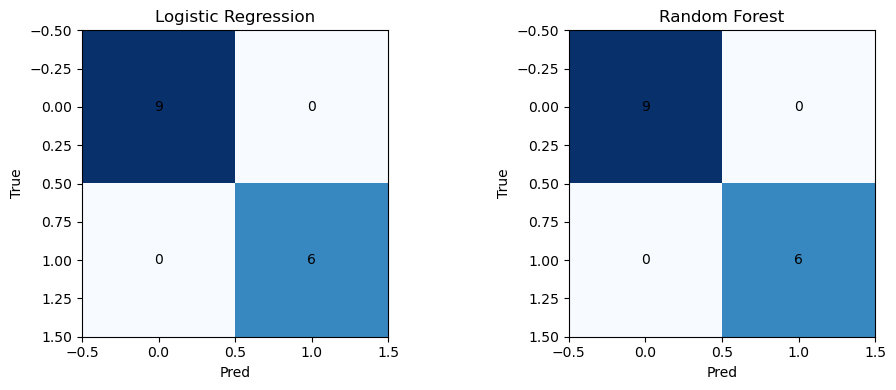

Saved: /Users/himalranabhat/Desktop/Crashspot/docs/figures/week5_model_eval.png


In [10]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y if y.nunique()==2 else None
)

# Preprocess: scale numeric, one-hot categorical
num_proc = Pipeline(steps=[("scaler", StandardScaler(with_mean=False))])
cat_proc = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown="ignore"))])

pre = ColumnTransformer(
    transformers=[
        ("num", num_proc, feature_cols_num),
        ("cat", cat_proc, feature_cols_cat)
    ]
)

# Models
log_reg = Pipeline(steps=[("pre", pre), ("clf", LogisticRegression(max_iter=200, n_jobs=None))])
rf_clf  = Pipeline(steps=[("pre", pre), ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf
}

results = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1  = f1_score(y_test, pred, zero_division=0)
    results[name] = {"acc": acc, "f1": f1, "pred": pred}
    print(f"{name}: acc={acc:.3f} | f1={f1:.3f}")

# Save evaluation plot (confusion matrices)
fig, axes = plt.subplots(1, len(models), figsize=(10,4))
if len(models)==1:
    axes = [axes]
for ax, (name, r) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, r["pred"])
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(name)
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, int(v), ha="center", va="center")
plt.tight_layout()
plt.savefig(EVAL_PNG, dpi=160)
plt.show()
print("Saved:", EVAL_PNG)


## 5) Random Forest feature importances (optional)

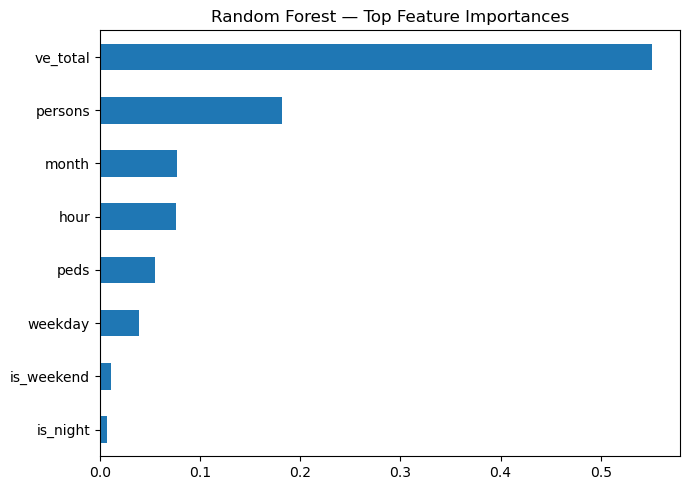

Saved: /Users/himalranabhat/Desktop/Crashspot/docs/figures/week5_rf_feature_importance.png


In [11]:

if "Random Forest" in models:
    rf = models["Random Forest"]
    # Recover feature names after preprocessing
    # Build preprocesser alone to infer names
    pre_only = rf.named_steps["pre"]
    pre_only.fit(X_train, y_train)
    num_names = feature_cols_num
    if feature_cols_cat:
        ohe = pre_only.named_transformers_["cat"].named_steps["ohe"]
        cat_names = list(ohe.get_feature_names_out(feature_cols_cat))
    else:
        cat_names = []
    all_names = num_names + cat_names

    # Extract trained RF estimator and its importances
    clf = rf.named_steps["clf"]
    importances = clf.feature_importances_
    # Guard: lengths may mismatch if transformers drop all-cat; align
    k = min(len(all_names), len(importances))
    imp = pd.Series(importances[:k], index=all_names[:k]).sort_values(ascending=False)[:20]

    plt.figure(figsize=(7,5))
    imp[::-1].plot.barh()
    plt.title("Random Forest — Top Feature Importances")
    plt.tight_layout()
    plt.savefig(RF_IMP_PNG, dpi=160)
    plt.show()
    print("Saved:", RF_IMP_PNG)
else:
    print("RF not available; skipping importances.")


## 6) Save final feature table

In [12]:

to_save = df[feature_cols_num + feature_cols_cat + ["target_multiveh"]].copy()
to_save.to_csv(FEATS_CSV, index=False)
print("Saved features to:", FEATS_CSV)
to_save.head()


Saved features to: /Users/himalranabhat/Desktop/Crashspot/data_clean/week5_features.csv


,hour,month,weekday,is_weekend,is_night,ve_total,persons,peds,target_multiveh
0,6,1,4,0,0,2,3,0,1
1,22,1,2,0,1,1,3,1,0
2,13,3,3,0,0,1,2,0,0
3,10,2,1,0,0,2,2,0,1
4,19,3,4,0,0,1,1,1,0
